In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Load in the data
!unzip "/content/gdrive/My Drive/Research/set-a-text.zip"
!unzip "/content/gdrive/My Drive/Research/set-a-text-test.zip"
!unzip "/content/gdrive/My Drive/Research/set-a-ext-text.zip"
!unzip "/content/gdrive/My Drive/Research/set-a-ext-text-test.zip"

Archive:  /content/gdrive/My Drive/Research/set-a-text.zip
replace a01.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: a01.csv                 
  inflating: __MACOSX/._a01.csv      
  inflating: a02.csv                 
  inflating: __MACOSX/._a02.csv      
  inflating: a03.csv                 
  inflating: __MACOSX/._a03.csv      
  inflating: a04.csv                 
  inflating: a05.csv                 
  inflating: a06.csv                 
  inflating: a07.csv                 
  inflating: a08.csv                 
  inflating: a09.csv                 
  inflating: a10.csv                 
  inflating: a11.csv                 
  inflating: a12.csv                 
  inflating: a13.csv                 
  inflating: a14.csv                 
  inflating: a15.csv                 
  inflating: a16.csv                 
  inflating: a17.csv                 
  inflating: a18.csv                 
  inflating: a19.csv                 
  inflating: a20.csv                 
  inflatin

In [3]:
%%capture
import pandas as pd
import numpy as np
X = []
Y = []

number_of_files = 9

for i in range(1, number_of_files+1):
    df = pd.read_csv("a0{}.csv".format(i), skiprows=[1])
    df.rename(columns={"\'Elapsed time\'": "elapsedTime", "\'AECG1\'": "AECG1", "\'AECG2\'": "AECG2", "\'AECG3\'": "AECG3", "\'AECG4\'":"AECG4"}, inplace=True)
    df['fetal'] = 0
    X.append(df)
    y = np.loadtxt("a0{}.fqrs.txt".format(i)).astype(int)
    Y.append(y)

number_of_files = 76

for i in range(10, number_of_files):
    df = pd.read_csv("a{}.csv".format(i), skiprows=[1])
    df.rename(columns={"\'Elapsed time\'": "elapsedTime", "\'AECG1\'": "AECG1", "\'AECG2\'": "AECG2", "\'AECG3\'": "AECG3", "\'AECG4\'":"AECG4"}, inplace=True)
    df['fetal'] = 0
    X.append(df)
    y = np.loadtxt("a{}.fqrs.txt".format(i)).astype(int)
    Y.append(y)

In [4]:
for i in range(len(X)):
  for j in range(len(Y[i])):
    X[i].at[Y[i][j],'fetal']=1

In [5]:
x0 = np.array(X[0]['AECG1'])
x = np.zeros(len(x0))
for i in range(0,len(x)):
    idx = range(max(0, i-35),min(len(x), i+36))
    x[i] = x0[i] - np.median(x0[idx])

pre = np.zeros(6000)
j = 0
for i in range(0,len(x), 10):
  pre[j] = x[i]
  j += 1
post = np.array(pre)

In [6]:
import altair as alt
alt.data_transformers.disable_max_rows()
x1 = np.arange(0, 60, .01)
filter = pd.DataFrame({"time":x1,"post":post})
DownSample = alt.Chart(filter[:1000]).mark_line().encode(
    x='time:Q',
    y='post:Q'
).properties(
    width=3000,
    height=250
)
#plt.plot(x1, x)
DownSample

alt.Chart(...)

In [7]:
from sklearn.decomposition import FastICA
x = X[0][['AECG1','AECG3']]
ica = FastICA(n_components=2)
S_ =ica.fit_transform(x)
A_ = ica.mixing_

In [8]:
A_

array([[ -325.90969121, -2485.11826794],
       [-1532.09097454,  1147.85393197]])

In [9]:
!unzip "/content/gdrive/My Drive/Research/edf_files.zip"

Archive:  /content/gdrive/My Drive/Research/edf_files.zip
  inflating: r07.edf.qrs             
  inflating: r01.edf.qrs             
  inflating: r08.edf.qrs             
  inflating: r07.edf                 
  inflating: r10.edf.qrs             
  inflating: r04.edf.qrs             
  inflating: r01.edf                 
  inflating: r08.edf                 
  inflating: r04.edf                 
  inflating: r10.edf                 


In [10]:
%%capture
!pip install pyedflib
import pyedflib
from pyedflib import highlevel

signals1, signal1_headers1, header1 = highlevel.read_edf('/content/r01.edf')
signals4, signal_headers4, header4 = highlevel.read_edf('/content/r04.edf')
signals7, signal_headers7, header7 = highlevel.read_edf('/content/r07.edf')
signals8, signal_headers8, header8 = highlevel.read_edf('/content/r08.edf')
signals10, signal_headers10, header10 = highlevel.read_edf('/content/r10.edf')

In [11]:
def columnRpeak(df, peaks):
  print("Amount of fetal R peaks:", len(peaks))
  print('Average fetal beat per minute:', len(peaks)/5)
  df['Rpeaks'] = 0
  for i in range(len(peaks)):
    index = round(peaks[i]*1000)
    df.at[index,'Rpeaks']=1
  return df

In [12]:
peaks1 = [row[0] for row in header1['annotations']]
df = pd.DataFrame(signals1.T)
df1 = columnRpeak(df, peaks1)
df1.rename(columns={0: "fetalECG", 1: "AECG1", 2: "AECG2", 3: "AECG3", 4:"AECG4"}, inplace=True)
df1['time'] = np.arange(0,300000)
df1.head

Amount of fetal R peaks: 644
Average fetal beat per minute: 128.8


<bound method NDFrame.head of          fetalECG      AECG1      AECG2      AECG3      AECG4  Rpeaks    time
0       28.750439  -8.850135  13.350204  22.050336  32.550497       0       0
1       26.650407 -13.950213  12.650193  21.750332  35.350539       0       1
2       24.750378 -18.750286  12.050184  21.250324  37.550573       0       2
3       23.750362 -23.450358  11.450175  20.250309  38.950594       0       3
4       23.550359 -27.950426  10.450159  18.550283  39.450602       0       4
...           ...        ...        ...        ...        ...     ...     ...
299995  53.850822   9.250141  -0.650010   0.350005   0.350005       0  299995
299996  51.950793   9.050138  -0.250004   0.850013  -0.150002       0  299996
299997  51.050779   8.950137   0.150002   1.450022  -0.350005       0  299997
299998  50.850776   8.950137   0.450007   2.050031  -0.050001       0  299998
299999  50.950777   9.050138   0.650010   2.150033   0.550008       0  299999

[300000 rows x 7 columns]>

In [31]:
sliced = df[:1000][['time','AECG1','AECG2','AECG3','AECG4','fetalECG']]
sliced_long =  pd.melt(sliced, ['time'])

sliced_long.rename(columns = {'variable':'channel', 'value':'ECG'}, inplace = True)
channels = [None] + list(sliced_long['channel'].unique())
channels_labels = ["All"] + list(sliced_long['channel'].unique())
sliced_long.head()

,time,channel,ECG
0,0,AECG1,-8.850135
1,1,AECG1,-13.950213
2,2,AECG1,-18.750286
3,3,AECG1,-23.450358
4,4,AECG1,-27.950426


In [32]:
import altair as alt
alt.data_transformers.disable_max_rows()
fetal = alt.Chart(sliced_long).mark_line().encode(
    x='time:Q',
    y='ECG:Q',
    color='channel:N'
).properties(
    width=3000,
    height=250
)
fetal

alt.Chart(...)

###PCA


In [33]:
from sklearn.preprocessing import StandardScaler
features = ['time', 'AECG1','AECG2', 'AECG3', 'AECG4']
x = df1.loc[:, features].values

y = df1.loc[:,['Rpeaks']].values

x = StandardScaler().fit_transform(x)
#pd.DataFrame(x)

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principleComponents = pca.fit_transform(x)
principleDf = pd.DataFrame(data = principleComponents, columns= ['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])
#principleDf.head

In [35]:
finalDf = pd.concat([principleDf, df[['Rpeaks']]], axis = 1)
finalDf.head

<bound method NDFrame.head of              pc1       pc2       pc3       pc4       pc5  Rpeaks
0      -2.072829  0.550640  1.740671  0.626675  0.169493       0
1      -2.156036  0.817933  1.742498  0.605684  0.126229       0
2      -2.215008  1.062710  1.744072  0.569935  0.082798       0
3      -2.231715  1.293417  1.745386  0.509291  0.031372       0
4      -2.187061  1.511612  1.746473  0.430391 -0.028383       0
...          ...       ...       ...       ...       ...     ...
299995  0.051430 -0.343815 -1.733230  0.264021 -0.003094       0
299996  0.036080 -0.355019 -1.733442  0.234953  0.023747       0
299997  0.009239 -0.365653 -1.733579  0.218599  0.049058       0
299998 -0.028608 -0.369775 -1.733559  0.223516  0.065952       0
299999 -0.052148 -0.366524 -1.733444  0.242488  0.054708       0

[300000 rows x 6 columns]>

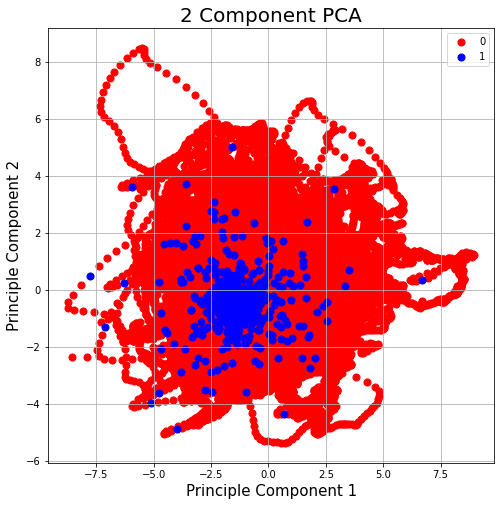

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principle Component 1', fontsize = 15)
ax.set_ylabel('Principle Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
  indicesToKeep = finalDf['Rpeaks'] == target
  ax.scatter(finalDf.loc[indicesToKeep, 'pc1'], finalDf.loc[indicesToKeep, 'pc2'], c = color, s = 50 )

ax.legend(targets)
ax.grid()

In [19]:
pca.explained_variance_ratio_

array([0.28872664, 0.21379934, 0.20000032, 0.16024975, 0.13722395])

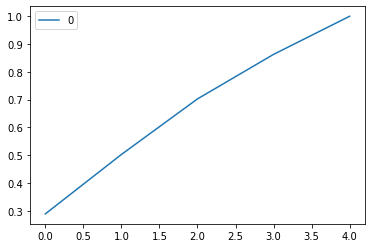

In [20]:
cs = pd.DataFrame(pca.explained_variance_ratio_.cumsum())
cs.plot()

###ICA

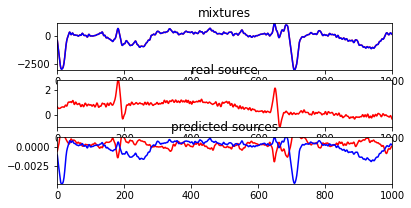

In [21]:
from sklearn.decomposition import FastICA
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
import seaborn as sns
X = df1.loc[:, ['AECG1', 'AECG2']].values
X -= X.mean(axis=0)
X /= X.std(axis=0)
A = np.array([[1000, 1], [1010, 1]])
S = np.dot(X, A.T)
Y = df1.loc[:, ['fetalECG']].values
Y -= Y.mean(axis=0)
Y /= Y.std(axis=0)
ica = FastICA(n_components=2)
S_ = ica.fit_transform(S)
fig = plt.figure()
models = [S, Y, S_]
names = ['mixtures', 'real source', 'predicted sources']
colors = ['red', 'blue']
for i, (name, model) in enumerate(zip(names, models)):
    plt.subplot(4, 1, i+1)
    plt.title(name)
    for sig, color in zip (model.T, colors):
        plt.plot(sig, color=color)
        plt.xlim([0, 1000])
        plt.ylim([min(sig[:1000]), max(sig[:1000])])

 
plt.show()

In [22]:
r01 = pd.DataFrame({
    "direct":signals1[0],
    "ch1":signals1[1],
    "ch2":signals1[2],
    "ch3":signals1[3],
    "ch4":signals1[4],
})

In [23]:
x0 = np.array(r01['ch1'])
x = np.zeros(len(x0))
for i in range(0,len(x)):
    idx = range(max(0, i-35),min(len(x), i+36))
    x[i] = x0[i] - np.median(x0[idx])

In [24]:
pre = np.zeros(30000)
j = 0
for i in range(0,300000, 10):
  pre[j] = x[i]
  j += 1
post = np.array(pre)

In [25]:
import altair as alt
alt.data_transformers.disable_max_rows()
x1 = np.arange(0, 30000, 1)
filter = pd.DataFrame({"time":x1,"post":post})
DownSample = alt.Chart(filter[:1000]).mark_line().encode(
    x='time:Q',
    y='post:Q'
).properties(
    width=3000,
    height=250
)
#plt.plot(x1, x)
DownSample

alt.Chart(...)

Shape of array: (501, 1501)
Datatype of array: float64


Text(0.5, 1.0, 'Power spectrogram')

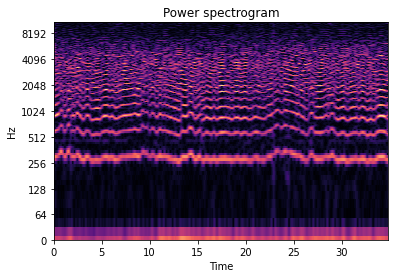

In [26]:
import librosa 
from librosa import display
import scipy
from scipy import signal
h = signal.windows.gaussian(700, std=150)
S = librosa.stft(post,n_fft=1000, hop_length=20, win_length=700, window=h, center=True)
A = np.abs(S)
print(f"Shape of array: {A.shape}")
print(f"Datatype of array: {A.dtype}")
fig, ax = plt.subplots()
img = librosa.display.specshow(A,y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')